# implement line sweeps of params
- all params fixed expcet one, which is swept over range
- specifically looking at test accuracy as a function of one param


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## timestamp and dir for saving
tstamp = time.perf_counter_ns()
import os
os.mkdir('figures/scratch_folders/%i'%tstamp)

In [3]:
## default params
expargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
schargs = {
    'concentration':1.4,
    'stickiness_wi':5000,
    'stickiness_bt':5, # 100
    'sparsity':0.08,
    'pvar': 2,
    'lrate':0.8,
    'lratep':1,
    'decay_rate':1,
} 
semargs = {
  'beta2':True
}
args = {
    'sem':semargs,
    'sch':schargs,
    'exp':expargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str += "-"+"-".join(["%s_%.3f"%(i,j) for i,j in semargs.items()])
param_str

'concentration_1.400-stickiness_wi_5000.000-stickiness_bt_5.000-sparsity_0.080-pvar_2.000-lrate_0.800-lratep_1.000-decay_rate_1.000-beta2_1.000'

In [4]:
# p_name = 'concentration' # 
# p_vals = np.arange(0.1,2.5,0.2)

# p_name = 'stickiness_wi' # 5000
# p_vals = np.arange(0,10000,500)

# p_name = 'stickiness_bt' # 100
# p_vals = np.arange(0,20,1)

# p_name = 'sparsity' # 0.08
# p_vals = np.arange(0.01,0.5,0.05)

# p_name = 'pvar' # 0
# p_vals = np.arange(1,2,0.1)

# p_name = 'lrate' # 1
# p_vals = np.arange(0.1,1,0.05)

p_name = 'lratep' # 1
p_vals = np.arange(0.1,1,0.05)

# p_name = 'decay_rate' # 1
# p_vals = np.arange(0.99,1.01,0.0005)

p_name,p_vals

('lratep',
 array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
        0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]))

### main

In [5]:
def pltsave_macc(macc,schargs=None,labL=['B','I','E','M','L'],close=True):
  """ 
  save accuracy of individual parameter setting 
  used in paramsearch loops
  """
  plt.figure(figsize=(10,4))
  ax=plt.gca()
  for idx in range(len(macc)):
    ax.plot(macc[idx],label=labL[idx])
  ax.axhline(0.5,c='k')
  plt.legend()
  param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
  plt.savefig('figures/scratch_folders/%i/acc-%s.jpg'%(tstamp,param_str))
  if close:
    plt.close('all')
  return None


In [6]:
ns = 15
dfL = []
condL = ['blocked','interleaved','early','middle','late']
for idx,p_val in enumerate(p_vals):
  print(idx/len(p_vals))
  
  args['sch'][p_name] = p_val  
  exp_batch_data = run_batch_exp_curr(ns,args,condL)
  ## acc
  batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
  mean_acc = batch_acc.mean(1)
  test_acc = mean_acc[:,-40:].mean(1) # curr  
  
  ## save traces of EML for each param setting
  pltsave_macc(mean_acc[2:],args['sch'],labL=['E','M','L'])
  
  ## record
  gsD = {
    **schargs,
    **dict(zip(condL,test_acc))
  }
  dfL.append(gsD)
  
gsdf = pd.DataFrame(dfL)

0.0
0.05555555555555555
0.1111111111111111
0.16666666666666666
0.2222222222222222
0.2777777777777778
0.3333333333333333
0.3888888888888889
0.4444444444444444
0.5
0.5555555555555556
0.6111111111111112
0.6666666666666666
0.7222222222222222
0.7777777777777778
0.8333333333333334
0.8888888888888888
0.9444444444444444


In [7]:
gsdf ## test acc dataframe

,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late
0,1.4,5000,5,0.08,2,0.8,0.10,1,0.477917,0.506667,0.486250,0.460000,0.498750
1,1.4,5000,5,0.08,2,0.8,0.15,1,0.493333,0.512500,0.515000,0.502917,0.482083
2,1.4,5000,5,0.08,2,0.8,0.20,1,0.507917,0.514583,0.500417,0.499583,0.509167
3,1.4,5000,5,0.08,2,0.8,0.25,1,0.497917,0.495000,0.497083,0.471250,0.507917
4,1.4,5000,5,0.08,2,0.8,0.30,1,0.489167,0.503750,0.501250,0.515833,0.527500
5,1.4,5000,5,0.08,2,0.8,0.35,1,0.485417,0.510833,0.507500,0.503333,0.510833
6,1.4,5000,5,0.08,2,0.8,0.40,1,0.518333,0.503333,0.495417,0.482917,0.535833
7,1.4,5000,5,0.08,2,0.8,0.45,1,0.519167,0.480417,0.487083,0.501667,0.520000
8,1.4,5000,5,0.08,2,0.8,0.50,1,0.504583,0.486250,0.485417,0.489583,0.496250
9,1.4,5000,5,0.08,2,0.8,0.55,1,0.490833,0.505000,0.498333,0.505417,0.492917


### plt 

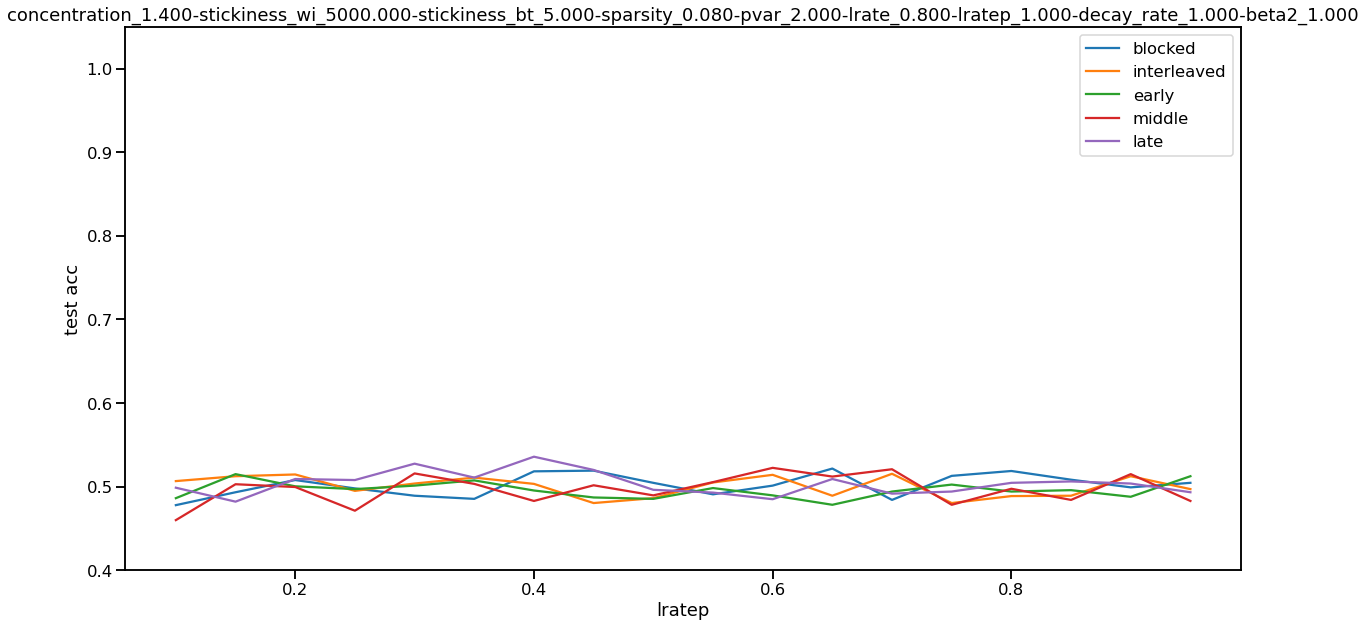

In [8]:
plt.figure(figsize=(20,10))
ax = plt.gca()
gsdf.plot(p_name,condL,ax=ax)
ax.set_ylim(0.4,1.05)
ax.set_ylabel('test acc')
plt.title(param_str)
plt.savefig('figures/scratch/testacc-sweep_%s-default_%s-t%s.png'%(
  p_name,param_str,tstamp))